In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import time

# Avoid Out of Memory Error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

2024-03-20 15:16:51.593921: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 15:16:54.293479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 15:16:54.304502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L3

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Load Data

In [2]:
# Build data pipline
training_data = tf.keras.utils.image_dataset_from_directory('Data_Subset', image_size=(250, 250))
val_data = tf.keras.utils.image_dataset_from_directory('Data_Subset_Validation', image_size=(250, 250))

data_iterator = training_data.as_numpy_iterator()
batch = data_iterator.next()

label_to_class_mapping = {label: class_name for label, class_name in enumerate(training_data.class_names)}

label_to_class_mapping

numeric_labels = batch[1]

# Convert numeric labels to class names
class_names = [label_to_class_mapping[label] for label in numeric_labels]

Found 16416 files belonging to 21 classes.
Found 4101 files belonging to 21 classes.


2024-03-20 15:16:56.671294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 15:16:56.671515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 15:16:56.671640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

2. Preprocess Data

2.1 Scale Data

In [3]:
#Scale data from 0-255 to 0-1
training_data = training_data.map(lambda image,label: (image/255, label))
val_data = val_data.map(lambda image,label: (image/255, label))

scaled_iterator = training_data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()
# data.as_numpy_iterator().next()[0].max()

2024-03-20 15:17:00.093444: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16416]
	 [[{{node Placeholder/_4}}]]
2024-03-20 15:17:00.093844: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16416]
	 [[{{node Placeholder/_4}}]]


1.0

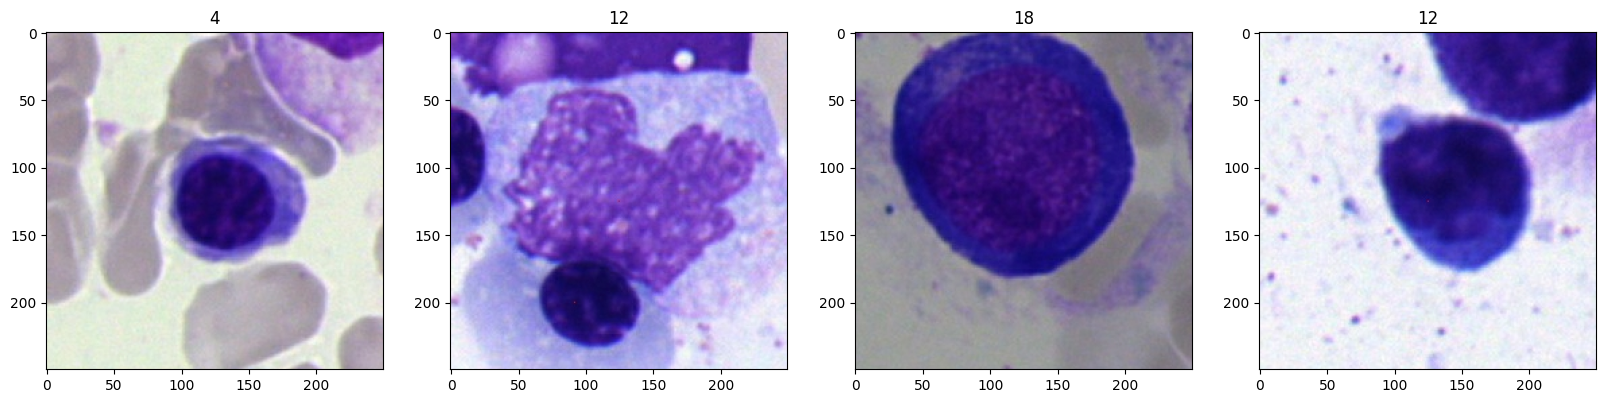

In [4]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

3. Deep Model

3.1 Build Deep Learning Model

In [5]:
model = Sequential()
# 16 filters, 3x3 size, stride of 1, 
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Fully connected layers
model.add(Dense(250, activation = 'relu'))
model.add(Dense(21, activation='softmax')) 

In [6]:
# Uses adam optimiser
model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 16)       0

3.2 Training

In [8]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [9]:
t0 = time.time()
hist = model.fit(training_data, epochs = 20, validation_data = val_data, callbacks = [tensorboard_callback])
t1 = time.time()-t0

print('Training time: ', t1)

Epoch 1/20


2024-03-20 15:17:10.362157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-03-20 15:17:10.692026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-20 15:17:10.760457: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x564eed999e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 15:17:10.760487: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-20 15:17:10.765511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-20 15:17:11.013002: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

512/513 [============================>.] - ETA: 0s - loss: 2.2420 - accuracy: 0.2773

2024-03-20 15:17:24.257548: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4101]
	 [[{{node Placeholder/_4}}]]
2024-03-20 15:17:24.257987: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4101]
	 [[{{node Placeholder/_4}}]]


513/513 [==============================] - 17s 27ms/step - loss: 2.2413 - accuracy: 0.2776 - val_loss: 1.9391 - val_accuracy: 0.3838
Epoch 2/20
513/513 [==============================] - 12s 24ms/step - loss: 1.7085 - accuracy: 0.4569 - val_loss: 1.6628 - val_accuracy: 0.4711
Epoch 3/20
513/513 [==============================] - 12s 24ms/step - loss: 1.3889 - accuracy: 0.5506 - val_loss: 1.6233 - val_accuracy: 0.5016
Epoch 4/20
513/513 [==============================] - 13s 25ms/step - loss: 1.1134 - accuracy: 0.6410 - val_loss: 1.7591 - val_accuracy: 0.4845
Epoch 5/20
513/513 [==============================] - 13s 24ms/step - loss: 0.8217 - accuracy: 0.7336 - val_loss: 2.0484 - val_accuracy: 0.4765
Epoch 6/20
513/513 [==============================] - 13s 24ms/step - loss: 0.5236 - accuracy: 0.8332 - val_loss: 2.5553 - val_accuracy: 0.4528
Epoch 7/20
513/513 [==============================] - 12s 24ms/step - loss: 0.3304 - accuracy: 0.8938 - val_loss: 3.1052 - val_accuracy: 0.4535
Epo

3.3 Plot Performance

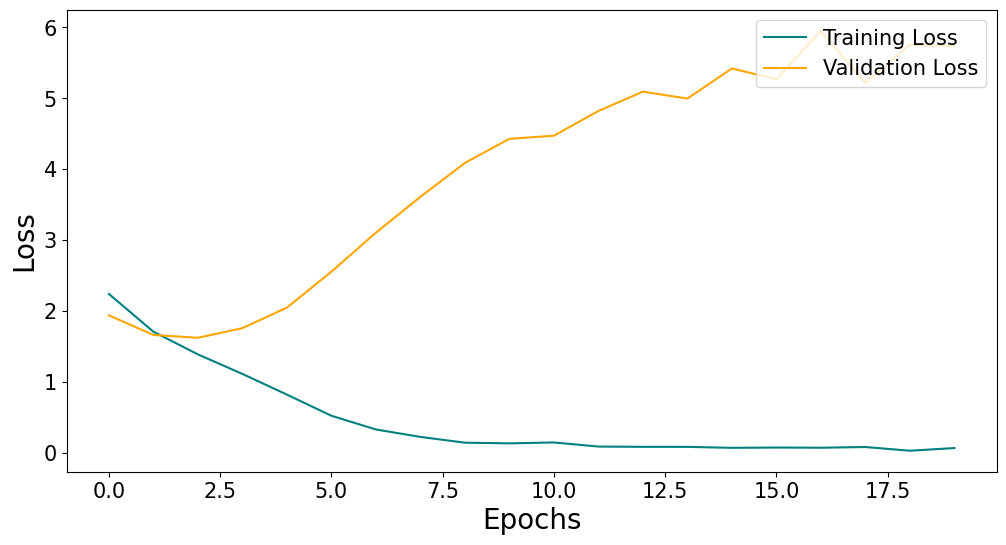

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'Training Loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'Validation Loss')
plt.legend(loc="upper right", fontsize=15)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.set_size_inches(12, 6)
plt.show()

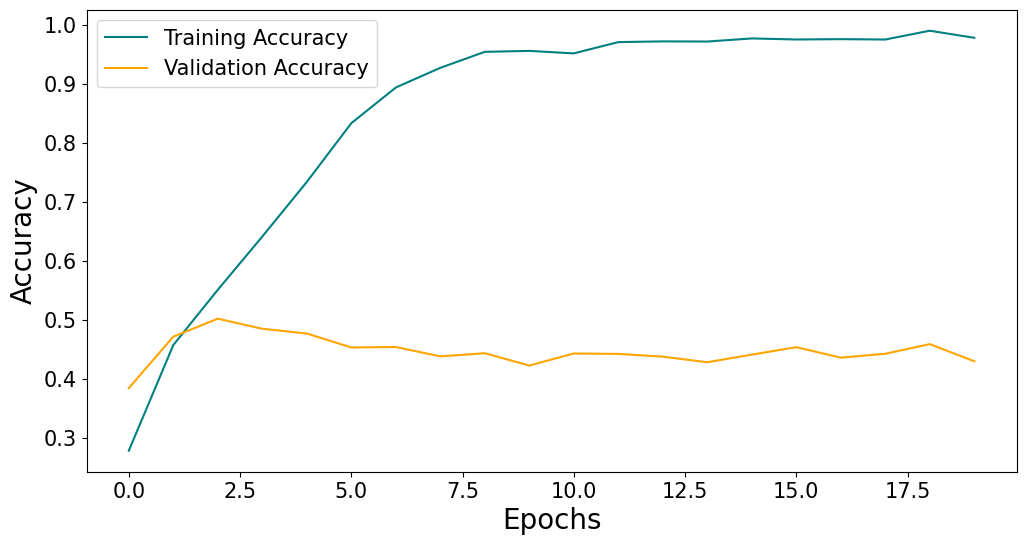

In [14]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc="upper left", fontsize=15)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.set_size_inches(12, 6)
plt.show()

In [15]:
folder = 'pickle'
inner_folder = 'first_model'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'wb') as f:
    pickle.dump(model, f)

In [16]:
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'wb') as f:
    pickle.dump(hist.history, f)

4. Evaluate Performance

4.1 Evaluate

In [17]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [18]:
y_true = []
y_pred = []

for batch in val_data.as_numpy_iterator():
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))

1/1 [==============================] - 0s 59ms/step


In [19]:
print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_labels = [str(i) for i in range(21)]
class_names = [label_to_class_mapping[label] for label in sorted(label_to_class_mapping.keys())]

# Generate classification report with specified labels
class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.4382762908935547, Recall:0.4216044843196869, Accuracy:0.4294074475765228
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.55      0.28      0.37       280
         BAS       0.07      0.08      0.08        61
         BLA       0.36      0.36      0.36       280
         EBO       0.48      0.73      0.58       280
         EOS       0.56      0.65      0.60       280
         FGC       0.00      0.00      0.00         6
         HAC       0.15      0.19      0.17        57
         KSC       0.22      0.33      0.27         6
         LYI       0.00      0.00      0.00         9
         LYT       0.42      0.55      0.48       280
         MMZ       0.25      0.29      0.27       280
         MON       0.40      0.24      0.30       280
         MYB       0.29      0.26      0.28       280
         NGB       0.36      0.25      0.30       280
         NGS       0.

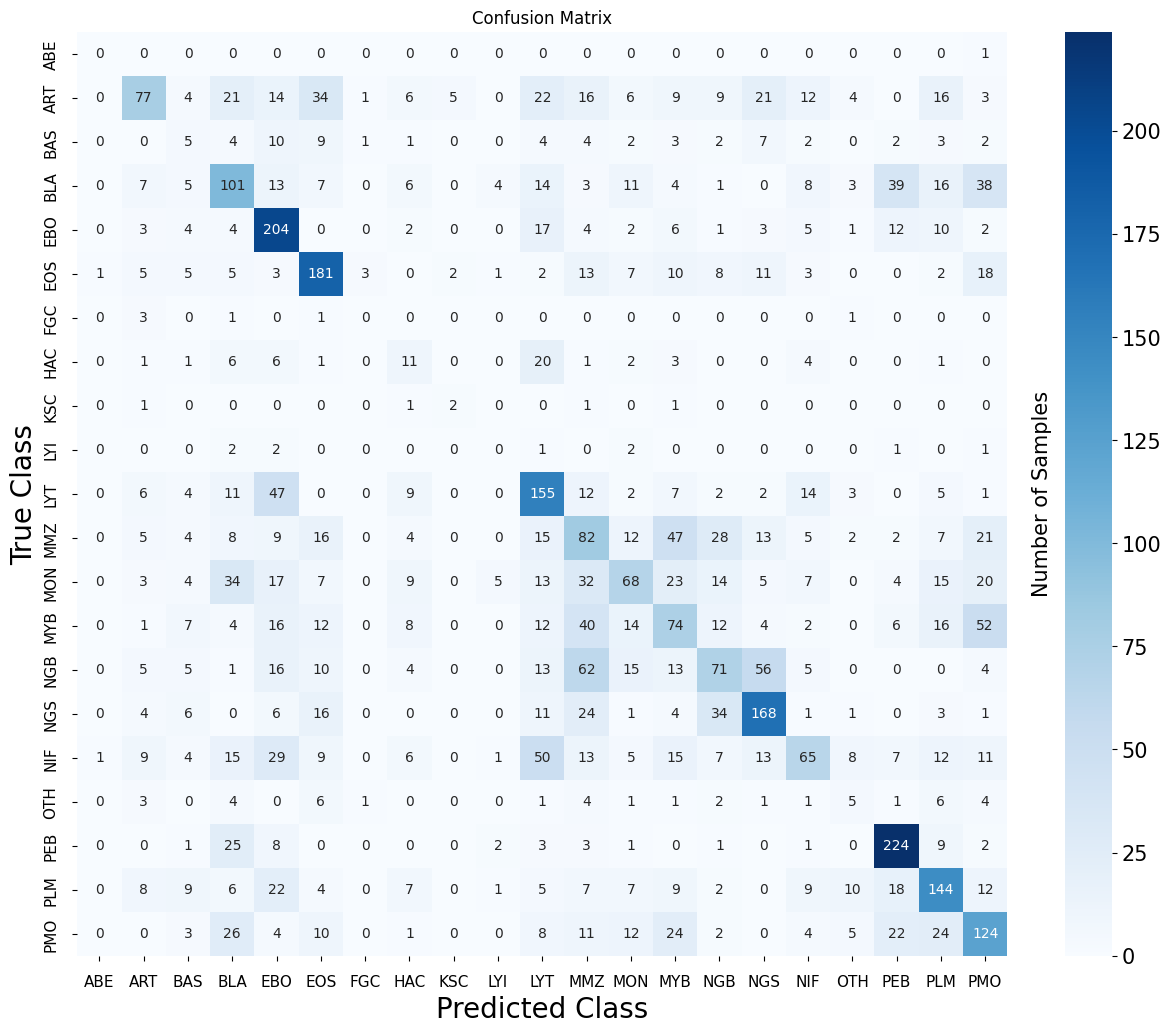

In [20]:
true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('True Class', fontsize=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
    
heatmap.tick_params(axis='x', which='major', pad=10)
heatmap.tick_params(axis='y', which='major', pad=10)
plt.title('Confusion Matrix')

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number of Samples', fontsize=15, rotation=90, labelpad=10)
cbar.ax.yaxis.set_label_position('left')
plt.show()

confusion_data = {
    'conf_matrix': conf_matrix,
    'class_labels': class_names,
}

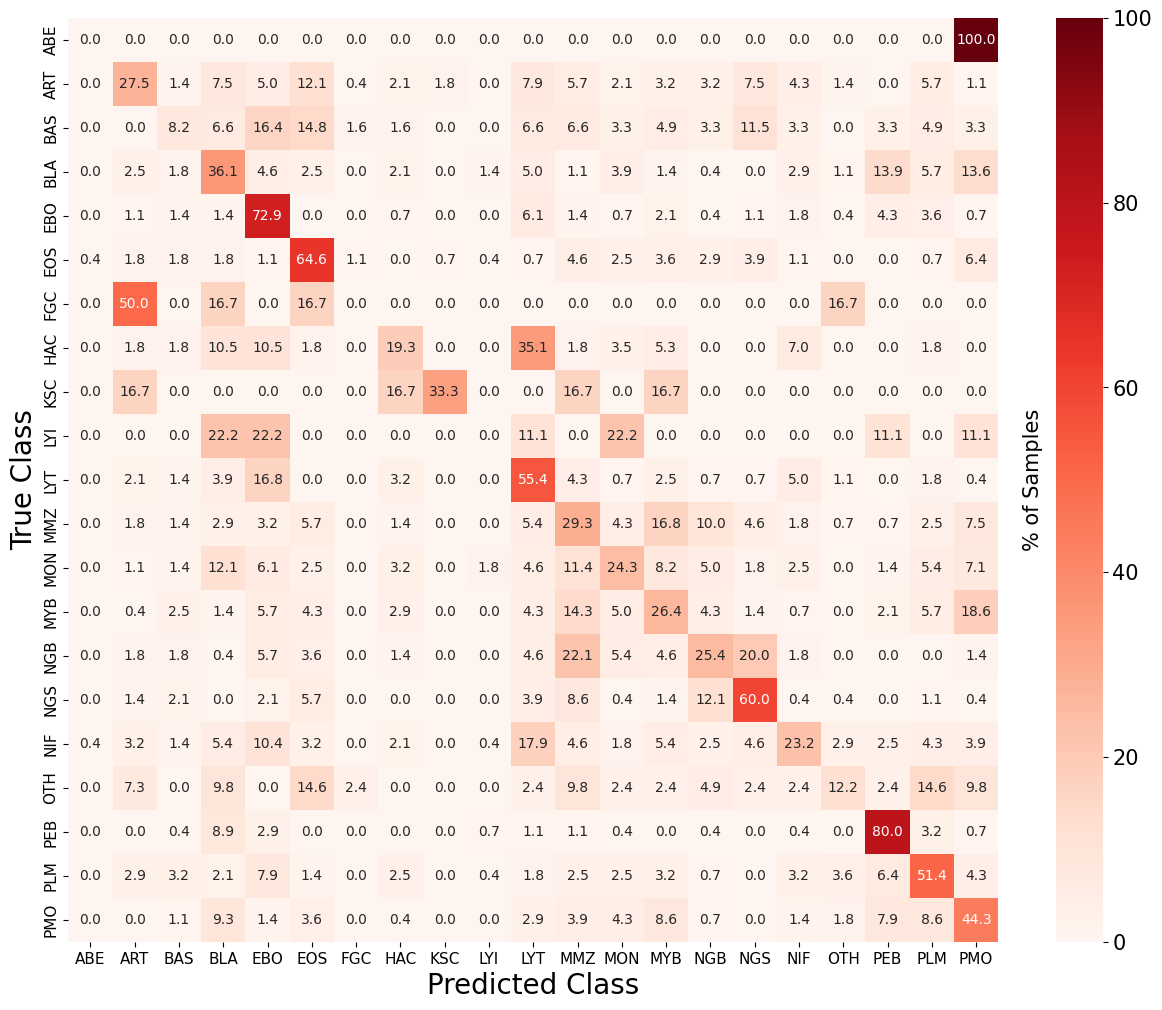

In [21]:
class_totals = np.sum(conf_matrix, axis=1)

normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i] * 100

# Plot the normalised confusion matrix with class names as tick labels
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(normalised_conf_matrix, annot=True, fmt='.1f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('True Class', fontsize=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label('% of Samples', fontsize=15, rotation=90, labelpad=10)
cbar.ax.yaxis.set_label_position('left')
plt.show()

normalised_confusion_data = {
    'normalised_conf_matrix': normalised_conf_matrix,
    'class_labels': class_names,
}

5. Save the model

In [22]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder,  'confusion_data'), 'wb') as f:
    pickle.dump(confusion_data, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_confusion_data, f)